# How to Implement Random Forest From Scratch in Python
### by [Jason Brownlee](https://machinelearningmastery.com/author/jasonb/) on July 31, 2020 in [Code Algorithms From Scratch](https://machinelearningmastery.com/category/algorithms-from-scratch/)

Decision trees can suffer from high variance which makes their results fragile to the specific training data used.

Building multiple models from samples of your training data, called bagging, can reduce this variance, but the trees are highly correlated.

[Random Forest](https://machinelearningmastery.com/random-forest-ensemble-in-python/) is an extension of bagging that in addition to building trees based on multiple samples of your training data, it also constrains the features that can be used to build the trees, forcing trees to be different. This, in turn, can give a lift in performance.

In this tutorial, you will discover how to implement the Random Forest algorithm from scratch in Python.

After completing this tutorial, you will know:

- The difference between bagged decision trees and the random forest algorithm.
- How to construct bagged decision trees with more variance.
- How to apply the random forest algorithm to a predictive modeling problem.

**Kick-start your project** with my new book [Machine Learning Algorithms From Scratch](https://machinelearningmastery.com/machine-learning-algorithms-from-scratch/), including step-by-step tutorials and the Python source code files for all examples.

Let’s get started.

- **Update Jan/2017:** Changed the calculation of fold_size in cross_validation_split() to always be an integer. Fixes issues with Python 3.
- **Update Feb/2017:** Fixed a bug in build_tree.
- **Update Aug/2017:** Fixed a bug in Gini calculation, added the missing weighting of group Gini scores by group size (thanks Michael!).
- **Update Aug/2018:** Tested and updated to work with Python 3.6.

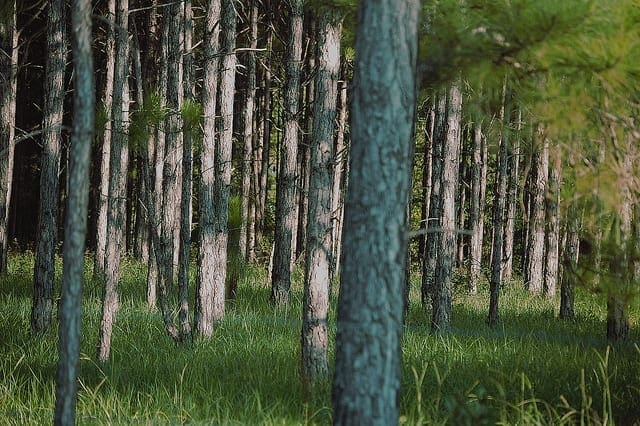
<center>How to Implement Random Forest From Scratch in Python - Photo by <a href="https://www.flickr.com/photos/inspirefatephotography/7569736320/">InspireFate Photography</a>, some rights reserved.</center>

## Description
This section provides a brief introduction to the Random Forest algorithm and the Sonar dataset used in this tutorial.

### Random Forest Algorithm
Decision trees involve the greedy selection of the best split point from the dataset at each step.

This algorithm makes decision trees susceptible to high variance if they are not pruned. This high variance can be harnessed and reduced by creating multiple trees with different samples of the training dataset (different views of the problem) and combining their predictions. This approach is called bootstrap aggregation or bagging for short.

A limitation of bagging is that the same greedy algorithm is used to create each tree, meaning that it is likely that the same or very similar split points will be chosen in each tree making the different trees very similar (trees will be correlated). This, in turn, makes their predictions similar, mitigating the variance originally sought.

We can force the decision trees to be different by limiting the features (rows) that the greedy algorithm can evaluate at each split point when creating the tree. This is called the Random Forest algorithm.

Like bagging, multiple samples of the training dataset are taken and a different tree trained on each. The difference is that at each point a split is made in the data and added to the tree, only a fixed subset of attributes can be considered.

For classification problems, the type of problems we will look at in this tutorial, the number of attributes to be considered for the split is limited to the square root of the number of input features.

`num_features_for_split = sqrt(total_input_features)`

The result of this one small change are trees that are more different from each other (uncorrelated) resulting predictions that are more diverse and a combined prediction that often has better performance that single tree or bagging alone.

### Sonar Dataset
The dataset we will use in this tutorial is the Sonar dataset.

This is a dataset that describes sonar chirp returns bouncing off different surfaces. The 60 input variables are the strength of the returns at different angles. It is a binary classification problem that requires a model to differentiate rocks from metal cylinders. There are 208 observations.

It is a well-understood dataset. All of the variables are continuous and generally in the range of 0 to 1. The output variable is a string “M” for mine and “R” for rock, which will need to be converted to integers 1 and 0.

By predicting the class with the most observations in the dataset (M or mines) the Zero Rule Algorithm can achieve an accuracy of 53%.

You can learn more about this dataset at the [UCI Machine Learning repository](https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks)).

Download the dataset for free and place it in your working directory with the filename **sonar.all-data.csv**

## Tutorial
This tutorial is broken down into 2 steps.

1. Calculating Splits.
2. Sonar Dataset Case Study.
These steps provide the foundation that you need to implement and apply the Random Forest algorithm to your own predictive modeling problems.

### 1. Calculating Splits
In a decision tree, split points are chosen by finding the attribute and the value of that attribute that results in the lowest cost.

For classification problems, this cost function is often the Gini index, that calculates the purity of the groups of data created by the split point. A Gini index of 0 is perfect purity where class values are perfectly separated into two groups, in the case of a two-class classification problem.

Finding the best split point in a decision tree involves evaluating the cost of each value in the training dataset for each input variable.

For bagging and random forest, this procedure is executed upon a sample of the training dataset, made with replacement. Sampling with replacement means that the same row may be chosen and added to the sample more than once.

We can update this procedure for Random Forest. Instead of enumerating all values for input attributes in search if the split with the lowest cost, we can create a sample of the input attributes to consider.

This sample of input attributes can be chosen randomly and without replacement, meaning that each input attribute needs only be considered once when looking for the split point with the lowest cost.

Below is a function name **get_split()** that implements this procedure. It takes a dataset and a fixed number of input features from to evaluate as input arguments, where the dataset may be a sample of the actual training dataset.

The helper function **test_split()** is used to split the dataset by a candidate split point and gini_index() is used to evaluate the cost of a given split by the groups of rows created.

We can see that a list of features is created by randomly selecting feature indices and adding them to a list (called **features**), this list of features is then enumerated and specific values in the training dataset evaluated as split points.

In [1]:
# Select the best split point for a dataset
def get_split(dataset, n_features):
	class_values = list(set(row[-1] for row in dataset))
	b_index, b_value, b_score, b_groups = 999, 999, 999, None
	features = list()
	while len(features) < n_features:
		index = randrange(len(dataset[0])-1)
		if index not in features:
			features.append(index)
	for index in features:
		for row in dataset:
			groups = test_split(index, row[index], dataset)
			gini = gini_index(groups, class_values)
			if gini < b_score:
				b_index, b_value, b_score, b_groups = index, row[index], gini, groups
	return {'index':b_index, 'value':b_value, 'groups':b_groups}

Now that we know how a decision tree algorithm can be modified for use with the Random Forest algorithm, we can piece this together with an implementation of bagging and apply it to a real-world dataset.

### 2. Sonar Dataset Case Study
In this section, we will apply the Random Forest algorithm to the Sonar dataset.

The example assumes that a CSV copy of the dataset is in the current working directory with the file name **sonar.all-data.csv**

The dataset is first loaded, the string values converted to numeric and the output column is converted from strings to the integer values of 0 and 1. This is achieved with helper functions **load_csv()**, **str_column_to_float()** and **str_column_to_int()** to load and prepare the dataset.

We will use k-fold cross validation to estimate the performance of the learned model on unseen data. This means that we will construct and evaluate k models and estimate the performance as the mean model error. Classification accuracy will be used to evaluate each model. These behaviors are provided in the **cross_validation_split()**, **accuracy_metric()** and **evaluate_algorithm()** helper functions.

We will also use an implementation of the Classification and Regression Trees (CART) algorithm adapted for bagging including the helper functions **test_split()** to split a dataset into groups, **gini_index()** to evaluate a split point, our modified **get_split()** function discussed in the previous step, **to_terminal()**, **split()** and **build_tree()** used to create a single decision tree, **predict()** to make a prediction with a decision tree, **subsample(**) to make a subsample of the training dataset and **bagging_predict()** to make a prediction with a list of decision trees.

A new function name **random_forest()** is developed that first creates a list of decision trees from subsamples of the training dataset and then uses them to make predictions.

As we stated above, the key difference between Random Forest and bagged decision trees is the one small change to the way that trees are created, here in the **get_split()** function.

The complete example is listed below.

In [2]:
# Random Forest Algorithm on Sonar Dataset
from random import seed
from random import randrange
from csv import reader
from math import sqrt

# Load a CSV file
def load_csv(filename):
	dataset = list()
	with open(filename, 'r') as file:
		csv_reader = reader(file)
		for row in csv_reader:
			if not row:
				continue
			dataset.append(row)
	return dataset

# Convert string column to float
def str_column_to_float(dataset, column):
	for row in dataset:
		row[column] = float(row[column].strip())

# Convert string column to integer
def str_column_to_int(dataset, column):
	class_values = [row[column] for row in dataset]
	unique = set(class_values)
	lookup = dict()
	for i, value in enumerate(unique):
		lookup[value] = i
	for row in dataset:
		row[column] = lookup[row[column]]
	return lookup

# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
	dataset_split = list()
	dataset_copy = list(dataset)
	fold_size = int(len(dataset) / n_folds)
	for i in range(n_folds):
		fold = list()
		while len(fold) < fold_size:
			index = randrange(len(dataset_copy))
			fold.append(dataset_copy.pop(index))
		dataset_split.append(fold)
	return dataset_split

# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	return correct / float(len(actual)) * 100.0

# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
	folds = cross_validation_split(dataset, n_folds)
	scores = list()
	for fold in folds:
		train_set = list(folds)
		train_set.remove(fold)
		train_set = sum(train_set, [])
		test_set = list()
		for row in fold:
			row_copy = list(row)
			test_set.append(row_copy)
			row_copy[-1] = None
		predicted = algorithm(train_set, test_set, *args)
		actual = [row[-1] for row in fold]
		accuracy = accuracy_metric(actual, predicted)
		scores.append(accuracy)
	return scores

# Split a dataset based on an attribute and an attribute value
def test_split(index, value, dataset):
	left, right = list(), list()
	for row in dataset:
		if row[index] < value:
			left.append(row)
		else:
			right.append(row)
	return left, right

# Calculate the Gini index for a split dataset
def gini_index(groups, classes):
	# count all samples at split point
	n_instances = float(sum([len(group) for group in groups]))
	# sum weighted Gini index for each group
	gini = 0.0
	for group in groups:
		size = float(len(group))
		# avoid divide by zero
		if size == 0:
			continue
		score = 0.0
		# score the group based on the score for each class
		for class_val in classes:
			p = [row[-1] for row in group].count(class_val) / size
			score += p * p
		# weight the group score by its relative size
		gini += (1.0 - score) * (size / n_instances)
	return gini

# Select the best split point for a dataset
def get_split(dataset, n_features):
	class_values = list(set(row[-1] for row in dataset))
	b_index, b_value, b_score, b_groups = 999, 999, 999, None
	features = list()
	while len(features) < n_features:
		index = randrange(len(dataset[0])-1)
		if index not in features:
			features.append(index)
	for index in features:
		for row in dataset:
			groups = test_split(index, row[index], dataset)
			gini = gini_index(groups, class_values)
			if gini < b_score:
				b_index, b_value, b_score, b_groups = index, row[index], gini, groups
	return {'index':b_index, 'value':b_value, 'groups':b_groups}

# Create a terminal node value
def to_terminal(group):
	outcomes = [row[-1] for row in group]
	return max(set(outcomes), key=outcomes.count)

# Create child splits for a node or make terminal
def split(node, max_depth, min_size, n_features, depth):
	left, right = node['groups']
	del(node['groups'])
	# check for a no split
	if not left or not right:
		node['left'] = node['right'] = to_terminal(left + right)
		return
	# check for max depth
	if depth >= max_depth:
		node['left'], node['right'] = to_terminal(left), to_terminal(right)
		return
	# process left child
	if len(left) <= min_size:
		node['left'] = to_terminal(left)
	else:
		node['left'] = get_split(left, n_features)
		split(node['left'], max_depth, min_size, n_features, depth+1)
	# process right child
	if len(right) <= min_size:
		node['right'] = to_terminal(right)
	else:
		node['right'] = get_split(right, n_features)
		split(node['right'], max_depth, min_size, n_features, depth+1)

# Build a decision tree
def build_tree(train, max_depth, min_size, n_features):
	root = get_split(train, n_features)
	split(root, max_depth, min_size, n_features, 1)
	return root

# Make a prediction with a decision tree
def predict(node, row):
	if row[node['index']] < node['value']:
		if isinstance(node['left'], dict):
			return predict(node['left'], row)
		else:
			return node['left']
	else:
		if isinstance(node['right'], dict):
			return predict(node['right'], row)
		else:
			return node['right']

# Create a random subsample from the dataset with replacement
def subsample(dataset, ratio):
	sample = list()
	n_sample = round(len(dataset) * ratio)
	while len(sample) < n_sample:
		index = randrange(len(dataset))
		sample.append(dataset[index])
	return sample

# Make a prediction with a list of bagged trees
def bagging_predict(trees, row):
	predictions = [predict(tree, row) for tree in trees]
	return max(set(predictions), key=predictions.count)

# Random Forest Algorithm
def random_forest(train, test, max_depth, min_size, sample_size, n_trees, n_features):
	trees = list()
	for i in range(n_trees):
		sample = subsample(train, sample_size)
		tree = build_tree(sample, max_depth, min_size, n_features)
		trees.append(tree)
	predictions = [bagging_predict(trees, row) for row in test]
	return(predictions)

# Test the random forest algorithm
seed(2)
# load and prepare data
filename = 'sonar.all-data.csv'
dataset = load_csv(filename)
# convert string attributes to integers
for i in range(0, len(dataset[0])-1):
	str_column_to_float(dataset, i)
# convert class column to integers
str_column_to_int(dataset, len(dataset[0])-1)
# evaluate algorithm
n_folds = 5
max_depth = 10
min_size = 1
sample_size = 1.0
n_features = int(sqrt(len(dataset[0])-1))
for n_trees in [1, 5, 10]:
	scores = evaluate_algorithm(dataset, random_forest, n_folds, max_depth, min_size, sample_size, n_trees, n_features)
	print('Trees: %d' % n_trees)
	print('Scores: %s' % scores)
	print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

Trees: 1
Scores: [56.09756097560976, 63.41463414634146, 60.97560975609756, 58.536585365853654, 73.17073170731707]
Mean Accuracy: 62.439%
Trees: 5
Scores: [70.73170731707317, 58.536585365853654, 85.36585365853658, 75.60975609756098, 63.41463414634146]
Mean Accuracy: 70.732%
Trees: 10
Scores: [75.60975609756098, 80.48780487804879, 92.6829268292683, 73.17073170731707, 70.73170731707317]
Mean Accuracy: 78.537%


A k value of 5 was used for cross-validation, giving each fold 208/5 = 41.6 or just over 40 records to be evaluated upon each iteration.

Deep trees were constructed with a max depth of 10 and a minimum number of training rows at each node of 1. Samples of the training dataset were created with the same size as the original dataset, which is a default expectation for the Random Forest algorithm.

The number of features considered at each split point was set to sqrt(num_features) or sqrt(60)=7.74 rounded to 7 features.

A suite of 3 different numbers of trees were evaluated for comparison, showing the increasing skill as more trees are added.

Running the example prints the scores for each fold and mean score for each configuration.

Trees: 1</br>
Scores: [56.09756097560976, 63.41463414634146, 60.97560975609756, 58.536585365853654, 73.17073170731707]</br>
Mean Accuracy: 62.439%

Trees: 5</br>
Scores: [70.73170731707317, 58.536585365853654, 85.36585365853658, 75.60975609756098, 63.41463414634146]</br>
Mean Accuracy: 70.732%

Trees: 10</br>
Scores: [75.60975609756098, 80.48780487804879, 92.6829268292683, 73.17073170731707, 70.73170731707317]</br>
Mean Accuracy: 78.537%

## Extensions
This section lists extensions to this tutorial that you may be interested in exploring.

- **Algorithm Tuning:** The configuration used in the tutorial was found with a little trial and error but was not optimized. Experiment with larger numbers of trees, different numbers of features and even different tree configurations to improve performance.
- **More Problems:** Apply the technique to other classification problems and even adapt it for regression with a new cost function and a new method for combining the predictions from trees.

<center><b>Did you try any of these extensions?</b></center>
<center>Share your experiences in the comments below.</center>

## Review
In this tutorial, you discovered how to implement the Random Forest algorithm from scratch.

Specifically, you learned:

- The difference between Random Forest and Bagged Decision Trees.
- How to update the creation of decision trees to accommodate the Random Forest procedure.
- How to apply the Random Forest algorithm to a real world predictive modeling problem.

<center><b>Do you have any questions?</b></center>
<center>Ask your questions in the comments below and I will do my best to answer.</center>

<center><h3>Discover How to Code Algorithms From Scratch!</h3></center>
<center><a href="/machine-learning-algorithms-from-scratch/"><img decoding="async" style="border: 0;" src="//wp-content/uploads/2022/11/MMLA-220.png" alt="Machine Learning Algorithms From Scratch" align="left" /></a></center>
<center><h4>No Libraries, Just Python Code.</h4></center>
<center><p>...with step-by-step tutorials on real-world datasets</p></center>
<center><p>Discover how in my new Ebook:<br></center>
<a href="/machine-learning-algorithms-from-scratch/" rel="nofollow">Machine Learning Algorithms From Scratch</a></p></center>
<center><p>It covers <strong>18 tutorials</strong> with all the code for <strong>12 top algorithms</strong>, like:<br>
Linear Regression, k-Nearest Neighbors, Stochastic Gradient Descent and much more...</p>
<center><h4>Finally, Pull Back the Curtain on<br>
Machine Learning Algorithms</h4></center>
<center><p>Skip the Academics. Just Results.</p></center>
<center><p><a href="/machine-learning-algorithms-from-scratch/" class="woo-sc-button  red"><span class="woo-">See What's Inside</span></a></p></center>